# 1. Import Library

In [18]:
import os
import pandas as pd
import difflib
from collections import defaultdict
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns

In [1]:
path_electricity_generation = r"D:\Code\BachKhoa\Khoa Hoc Du Lieu\eletricity-generation-predictor\CLEAN_DATA\Electricity_Generation_Processed.csv"
path_population = r"D:\Code\BachKhoa\Khoa Hoc Du Lieu\eletricity-generation-predictor\CLEAN_DATA\population_monthly.csv"
path_sunshine = r"D:\Code\BachKhoa\Khoa Hoc Du Lieu\eletricity-generation-predictor\CLEAN_DATA\sunshine_monthly.csv"
path_humidity = r"D:\Code\BachKhoa\Khoa Hoc Du Lieu\eletricity-generation-predictor\CLEAN_DATA\vietnam-humidity-handled-data.csv"
path_rainfall = r"D:\Code\BachKhoa\Khoa Hoc Du Lieu\eletricity-generation-predictor\CLEAN_DATA\vietnam-rainfall-handled-data.csv"
path_temperature = r"D:\Code\BachKhoa\Khoa Hoc Du Lieu\eletricity-generation-predictor\CLEAN_DATA\vietnam-temperature-handled-data.csv"

In [19]:
electricity_df = pd.read_csv(path_electricity_generation)
population_df = pd.read_csv(path_population)
sunshine_df = pd.read_csv(path_sunshine)
humidity_df = pd.read_csv(path_humidity)
rainfall_df = pd.read_csv(path_rainfall)
temperature_df = pd.read_csv(path_temperature)


In [2]:
# List các đường dẫn
paths = [
    path_electricity_generation,
    path_population,
    path_sunshine,
    path_humidity,
    path_rainfall,
    path_temperature,
]

In [3]:
YEARS = [year for year in range(2002, 2023)]

In [4]:
MONTHS = [month for month in range(1, 13)]

# 2. Visualizing Single Variable 

## 2.1 Electricity Generation

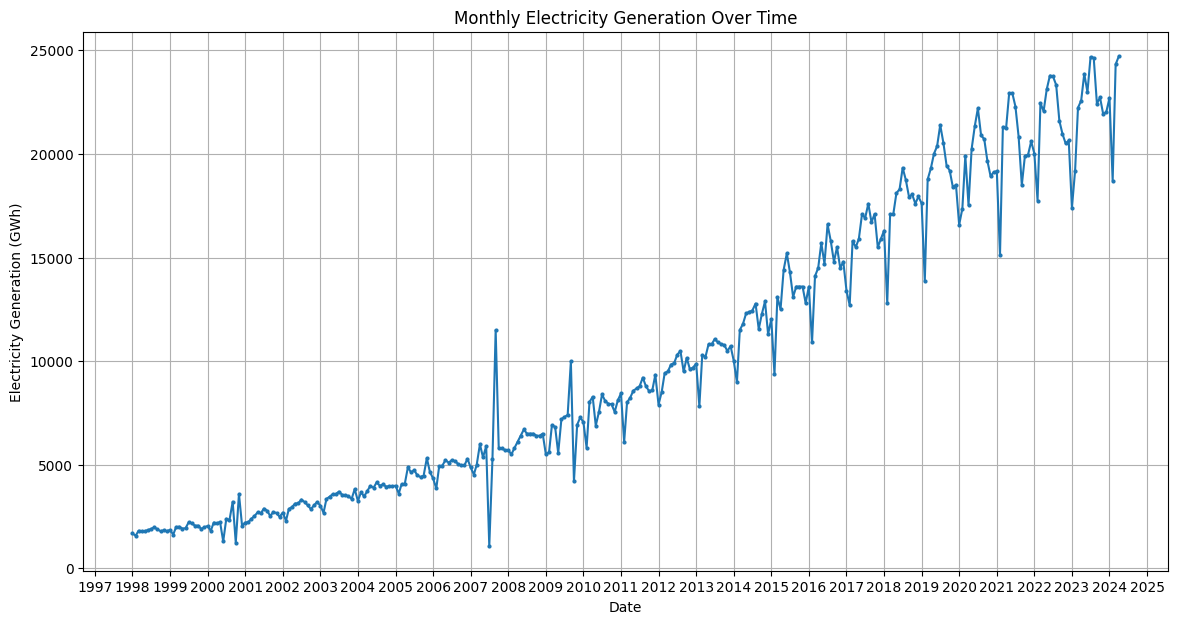

In [27]:
# Tạo cột Date từ Year và Month
electricity_df['Date'] = pd.to_datetime(electricity_df[['Year', 'Month']].assign(Day=1))

# Đặt cột Date làm chỉ mục
electricity_df.set_index('Date', inplace=True)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(electricity_df.index, electricity_df['Generation'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Electricity Generation (GWh)')
plt.title('Monthly Electricity Generation Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

## 2.2 Temperature Data

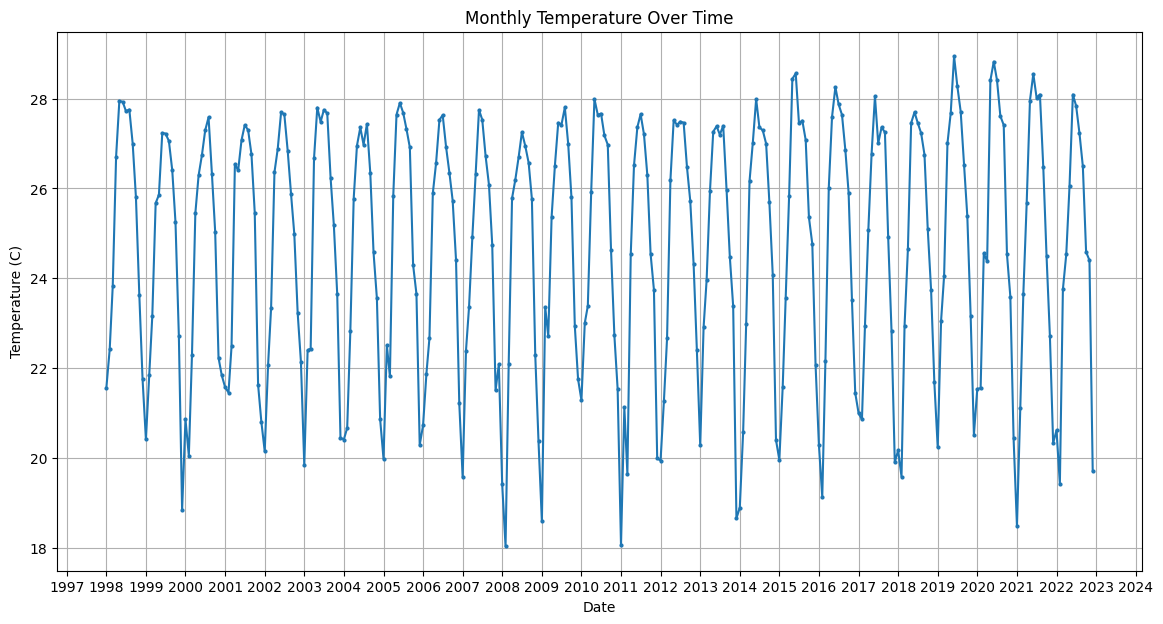

In [22]:
# Tạo cột Date từ Year và Month
temperature_df['Date'] = pd.to_datetime(temperature_df[['Year', 'Month']].assign(Day=1))

# Đặt cột Date làm chỉ mục
temperature_df.set_index('Date', inplace=True)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(temperature_df.index, temperature_df['Temperature'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Monthly Temperature Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

## 2.3 Humidity Data

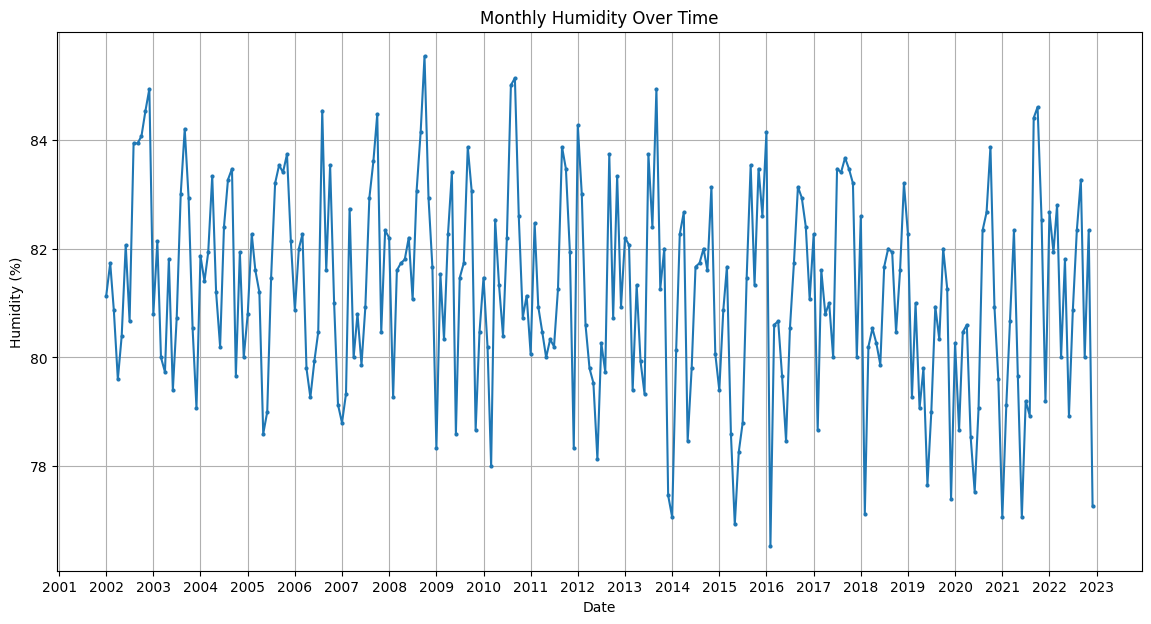

In [26]:
# Tạo cột Date từ Year và Month
humidity_df['Date'] = pd.to_datetime(humidity_df[['Year', 'Month']].assign(Day=1))

# Đặt cột Date làm chỉ mục
humidity_df.set_index('Date', inplace=True)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(humidity_df.index, humidity_df['Humidity'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Monthly Humidity Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

## 2.4 Rainfall Data

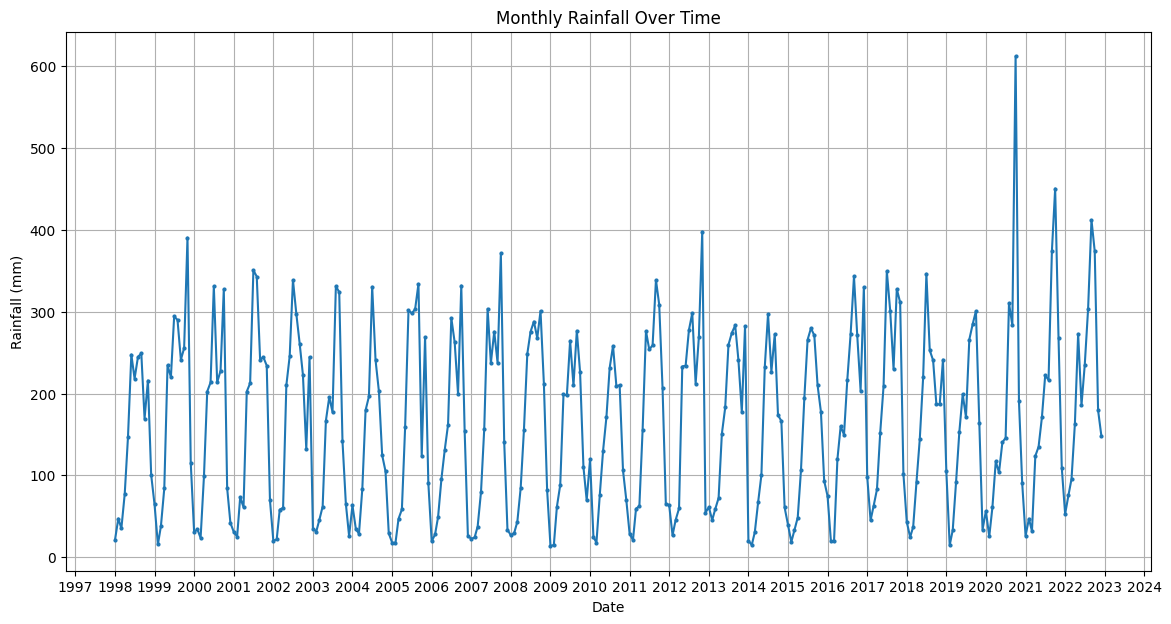

In [25]:
# Tạo cột Date từ Year và Month
rainfall_df['Date'] = pd.to_datetime(rainfall_df[['Year', 'Month']].assign(Day=1))

# Đặt cột Date làm chỉ mục
rainfall_df.set_index('Date', inplace=True)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(rainfall_df.index, rainfall_df['Rainfall'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Monthly Rainfall Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

## 2.5 Sunshine Data

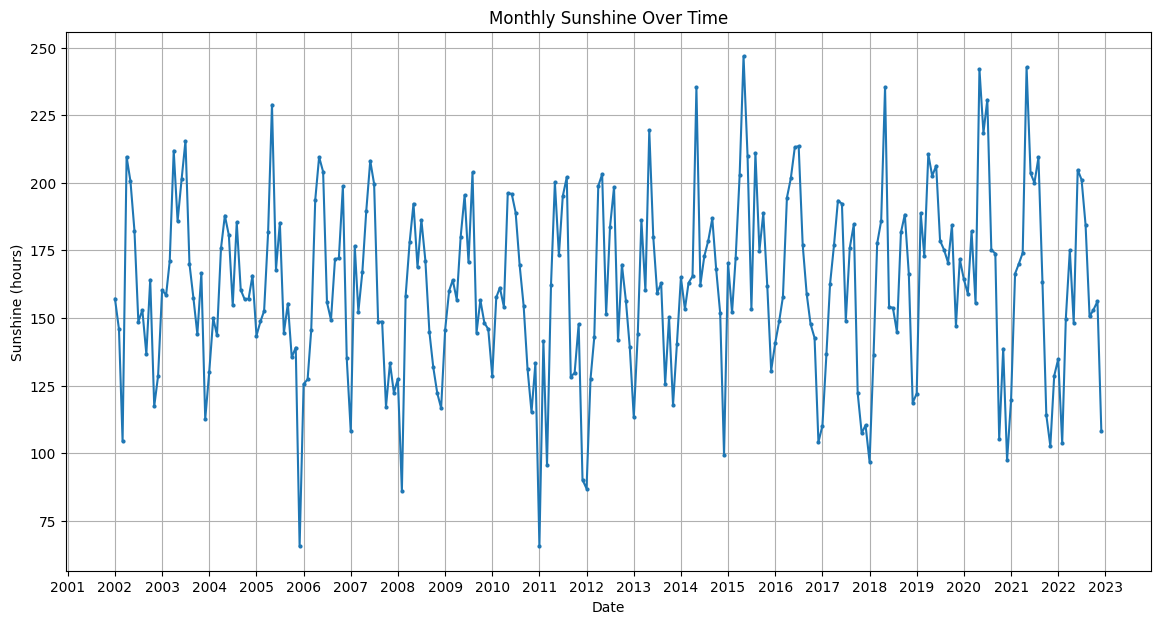

In [29]:
# Tạo cột Date từ Year và Month
sunshine_df['Date'] = pd.to_datetime(sunshine_df[['Year', 'Month']].assign(Day=1))

# Đặt cột Date làm chỉ mục
sunshine_df.set_index('Date', inplace=True)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(sunshine_df.index, sunshine_df['Average Sunshine'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Sunshine (hours)')
plt.title('Monthly Sunshine Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

## 2.6 Population Data

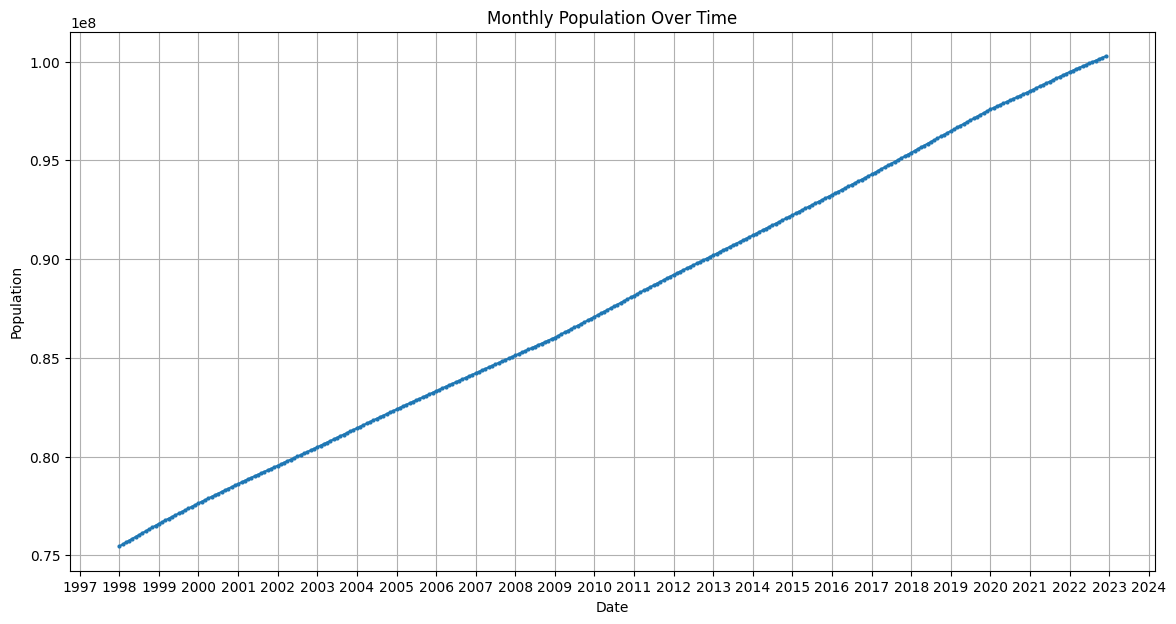

In [30]:
# Tạo cột Date từ Year và Month
population_df['Date'] = pd.to_datetime(population_df[['Year', 'Month']].assign(Day=1))

# Đặt cột Date làm chỉ mục
population_df.set_index('Date', inplace=True)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(population_df.index, population_df['Population'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('Monthly Population Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()